In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA
import scipy
from scipy import sparse as sp
from scipy.sparse import coo_matrix,spdiags,csr_matrix

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Inferring ranks and group preferences


$$ H^{++} = H(s, \theta) + \tfrac{1}{2} \lambda_s ||s||_2^2 + \tfrac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

In [2]:
N = 500
num_groups = {
              "cat_01" : 4,
             }
l0 = {
      "individual": 0.5,
      "cat_01": 2,
     }
alpha = {
         "individual": 1,
         "cat_01": 1,
        }
beta = 0.1
p_ij = 1 / (1 + np.exp(-2*beta))
K = 10

A, G, scores, ranks = sr.SpringRank_planted_network_groups(
                            N, num_groups, beta, alpha, K, np.random, l0, l1=1,
                            allow_self_loops=False, return_ranks=True)

A = np.array(nx.to_numpy_matrix(A))
G = G["cat_01"]

group_keys = G.nonzero()[1]

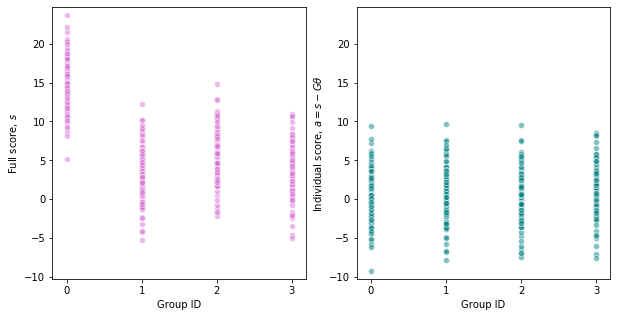

In [69]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

for i in range(2):
    ax[i].set_xticks(np.sort(np.unique(group_keys)))
    ax[i].set_xlabel("Group ID")
    ax[i].set_ylim(np.min(scores["individual"])-1, np.max(ranks)+1)

ax[0].scatter(group_keys, ranks, color="orchid", edgecolor="white", alpha=0.5)
ax[0].set_ylabel(r"Full score, $s$")

ax[1].scatter(group_keys, scores["individual"], color="teal", edgecolor="white", alpha=0.5)
ax[1].set_ylabel(r"Individual score, $a = s - G\theta$")

plt.show()

1. Find $s$
2. Compute $\theta$
3. Compare both hamiltonians
4. SBM version?

In [56]:
s = sr.SpringRank(A)
s = tl.shift_ranks(s)

theta = np.matmul(G.T, s) / np.sum(G.T, axis=1)

a = s - np.matmul(G, theta)

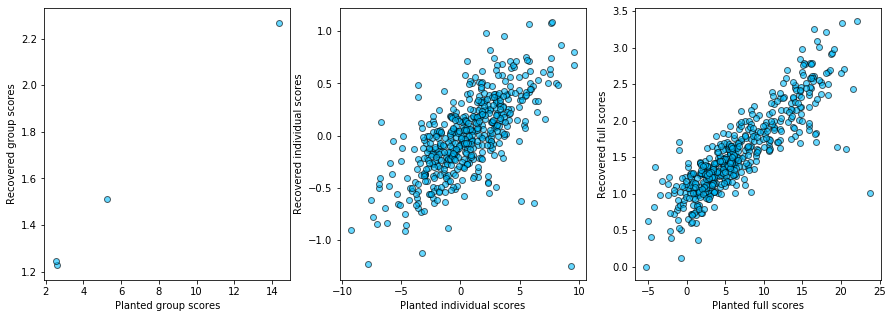

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(scores["cat_01"], theta, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[0].set_xlabel("Planted group scores")
ax[0].set_ylabel("Recovered group scores")

ax[1].scatter(scores["individual"], a, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[1].set_xlabel("Planted individual scores")
ax[1].set_ylabel("Recovered individual scores")

ax[2].scatter(ranks, s, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[2].set_xlabel("Planted full scores")
ax[2].set_ylabel("Recovered full scores")

plt.show()

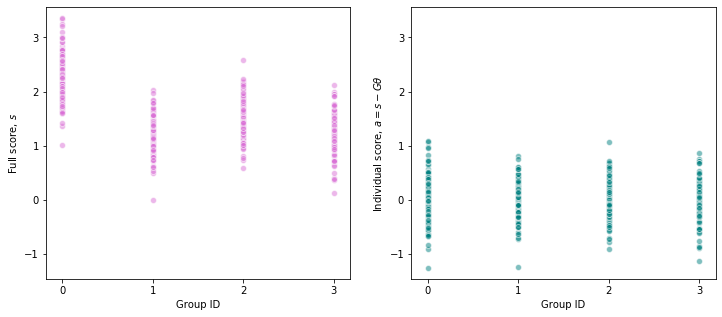

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i in range(2):
    ax[i].set_xticks(np.sort(np.unique(group_keys)))
    ax[i].set_xlabel("Group ID")
    ax[i].set_ylim(np.min(a)-0.2, np.max(s)+0.2)

ax[0].scatter(group_keys, s, color="orchid", edgecolor="white", alpha=0.5)
ax[0].set_ylabel(r"Full score, $s$")

ax[1].scatter(group_keys, a, color="teal", edgecolor="white", alpha=0.5)
ax[1].set_ylabel(r"Individual score, $a = s - G\theta$")

plt.show()

In [21]:
H_theta = 0
H_s = 0
H_a = 0
for i in range(N):
    for j in range(N):
        H_theta += A[i, j] * (theta[group_keys[i]] - theta[group_keys[j]] - 1)**2
        H_s += A[i, j] * (s[i] - s[j] - 1)**2
        H_a += A[i, j] * (a[i] - a[j] - 1)**2
        
print(H_s)
print(H_theta)
print(H_a)

4203.595401835744
5113.015990064782
4680.389520001448


Find the group scores by solving the "grouped" version of SpringRank

In [59]:
Omega = np.matmul(np.matmul(G.T, A), G)

theta = sr.SpringRank(Omega)

Feed in these group scores into further Hamiltonian calculations

In [60]:
k_out = np.sum(A, 1)
k_in = np.sum(A, 0)

D = np.diag(k_in + k_out)
L = D - (A + A.T)

theta_s = np.matmul(G, theta) # spread out theta for all nodes
d_hat = k_out - k_in
RHS = d_hat - np.matmul(L, theta_s)

result = LA.lstsq(L, RHS, rcond=-1)
a = result[0]

s = a + theta_s

In [61]:
a_mean = np.matmul(G.T, a) / np.sum(G.T, axis=1) # average a across all groups
a = a - np.matmul(G, a_mean) # shift so all of the a's have the same mean = 0
theta = theta + a_mean # we also need to shift the theta's
theta_s = np.matmul(G, theta)

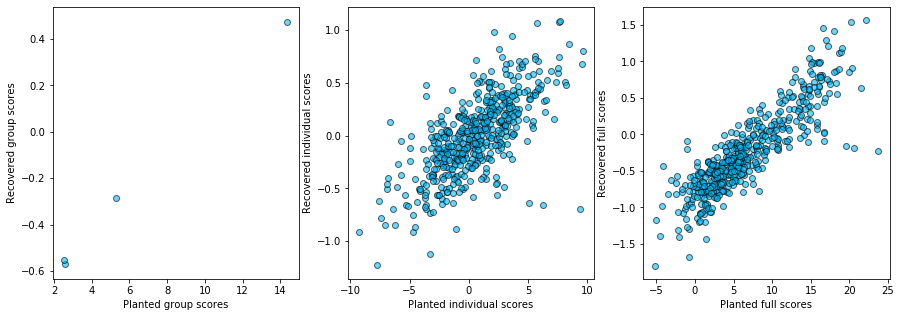

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].scatter(scores["cat_01"], theta, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[0].set_xlabel("Planted group scores")
ax[0].set_ylabel("Recovered group scores")

ax[1].scatter(scores["individual"], a, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[1].set_xlabel("Planted individual scores")
ax[1].set_ylabel("Recovered individual scores")

ax[2].scatter(ranks, s, color="deepskyblue", edgecolor="black", alpha=0.6)
ax[2].set_xlabel("Planted full scores")
ax[2].set_ylabel("Recovered full scores")

plt.show()

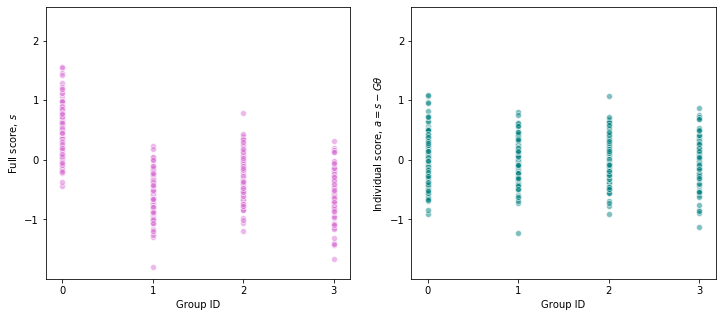

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

for i in range(2):
    ax[i].set_xticks(np.sort(np.unique(group_keys)))
    ax[i].set_xlabel("Group ID")
    ax[i].set_ylim(np.min(s)-0.2, np.max(s)+1)

ax[0].scatter(group_keys, s, color="orchid", edgecolor="white", alpha=0.5)
ax[0].set_ylabel(r"Full score, $s$")

ax[1].scatter(group_keys, a, color="teal", edgecolor="white", alpha=0.5)
ax[1].set_ylabel(r"Individual score, $a = s - G\theta$")

plt.show()

## Faculty Hiring

In [62]:
CS_adjacency_matrix = np.load("../../data/CS.npy")[:-1, :-1]
regions_list = np.load("../../data/CS_regions.npy")

clean_regions_idx = []
clean_regions_list = []
for idx, x in enumerate(regions_list):
    if x != 1:
        clean_regions.append(idx)
        clean_regions_list.append(x)
        
CS_clean = CS_adjacency_matrix[clean_regions_idx][:, clean_regions_idx]

In [51]:
G_regions = np.zeros((CS_adjacency_matrix.shape[0], np.max(regions_list)+1))
for i in range(len(regions_list)):
    G_regions[i, regions_list[i]] = 1
    
    
# clean

G_clean = np.zeros((CS_clean.shape[0], np.max(regions_list)))
for i in range(len(regions_list)):
    regions_idx = regions_list[i]
    if regions_idx == 1:
        continue
    elif regions_idx > 1:
        G_clean[i, regions_idx-2] = 1
    elif regions_idx == 0:
        G_clean[i, 0] = 1

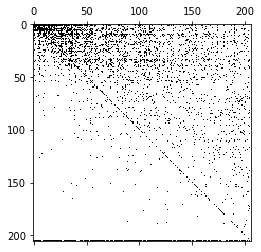

In [21]:
plt.spy(CS_adjacency_matrix)
plt.show()

In [52]:
G = {"regions": G_clean}
reg_coeff = {
             "individual": 1e-1,
             "regions": 1e-1,
            }

ranks_est, scores_est = sr.SpringRank_groups(CS_clean, G, reg_coeff, solver="bicgstab")

In [57]:
clean_regions_keys = list(regions_keys[:1]) + list(regions_keys[2:])

for region, rank in zip(clean_regions_keys, scores_est['regions']):
    print(region, rank)

Canada    -0.04373650157835568
Midwest   0.21944285875932598
Northeast -0.1916399875829317
South     0.01593363040211144
West      0.0


<Figure size 432x360 with 0 Axes>

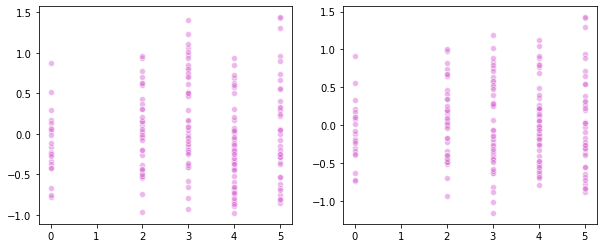

In [67]:
plt.figure(figsize=(6, 5))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(clean_regions_list, ranks_est, color="orchid", edgecolor="white", alpha=0.5)

ax[1].scatter(clean_regions_list, scores_est["individual"], color="orchid", edgecolor="white", alpha=0.5)

plt.show()

In [ ]:
np.matmul